# Analysis of tess observation of HIP-41378

In [1]:
from astropy.io import fits
from astropy.stats import sigma_clip
import numpy as np
import matplotlib.pylab as plt
from scipy.signal import medfilt
%matplotlib inline  


Text(0, 0.5, 'Flux')

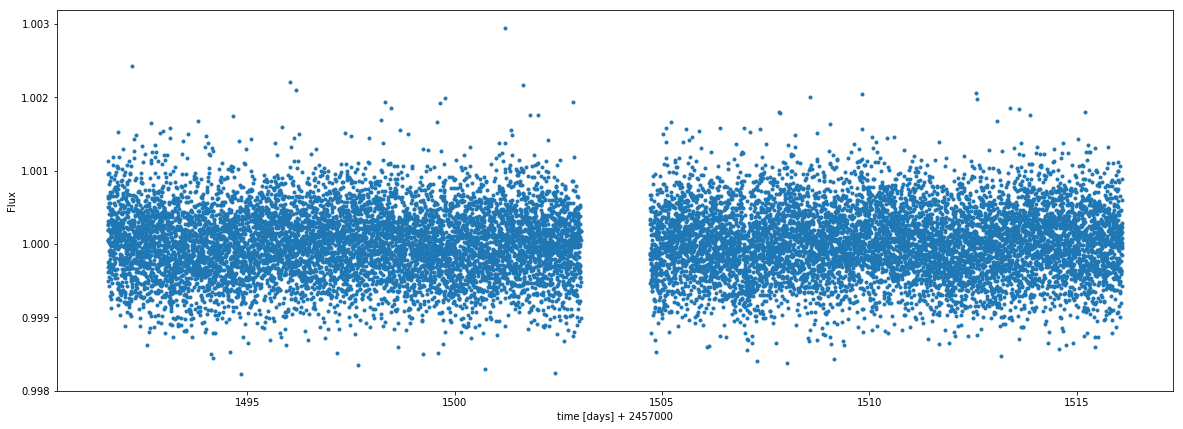

In [33]:
#load EXO file and k2sc file
hdu_list = fits.open('/home/tunde/Dropbox/Ph.D/notebooks/tess2019006130736-s0007-0000000366443426-0131-s_lc.fits')

q=hdu_list[1].data["QUALITY"]
time, flux, err = hdu_list[1].data["TIME"][q==0], hdu_list[1].data["PDCSAP_FLUX"][q==0], hdu_list[1].data["PDCSAP_FLUX_ERR"][q==0]

ind=np.argwhere(np.isfinite(flux))
time, flux, err= time[ind][:,0], flux[ind][:,0], err[ind][:,0]
#normalize the flux with the median
flux=flux/np.median(flux)


plt.figure(figsize=(20,7))
plt.plot(time,flux,".")
plt.xlabel("time [days] + 2457000")
plt.ylabel("Flux")


# Search for transits using BLS.

Because the transiting planet with the smallest period in the system is 15.57 days, periodicity cannot be seen in this 24-day TESS time-series. But we run a BLS anyways

In [23]:
from astropy.stats import BoxLeastSquares

bls_model = BoxLeastSquares(time,flux)

period_grid = np.linspace(8, 12, 100) # period grid to search
duration = np.linspace(0.1,0.8,50)  #duration to search

bls=bls_model.power(period_grid,  duration)

#find period with the maximum power
index = np.argmax(bls.power)
bls_power_max = bls.power[index]
bls_period = bls.period[index]
bls_t0 = bls.transit_time[index]
bls_depth = bls.depth[index]

Text(0, 0.5, 'Power')

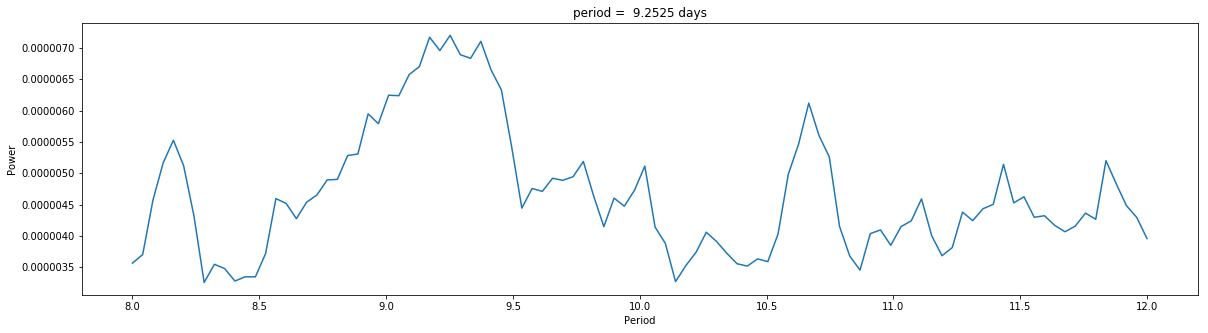

In [29]:
plt.figure(figsize=(20,5))
plt.plot(bls.period, bls.power)
plt.title("period =  {0:.4f} days".format(bls_period))
plt.xlabel("Period")
plt.ylabel("Power")


### Bin the light curve in 10mins

In [45]:
from scipy.stats import binned_statistic


bin_width=10./(24*60)
bins=np.arange(time.min(), time.max()+bin_width, bin_width)
y_bin=binned_statistic(time,flux,bins=bins,statistic=np.mean)[0]
t_bin=bins[1:] - bin_width/2.

/home/tunde/miniconda3/envs/python3_env/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0.5, 0, 'time + 2457000 [days]')

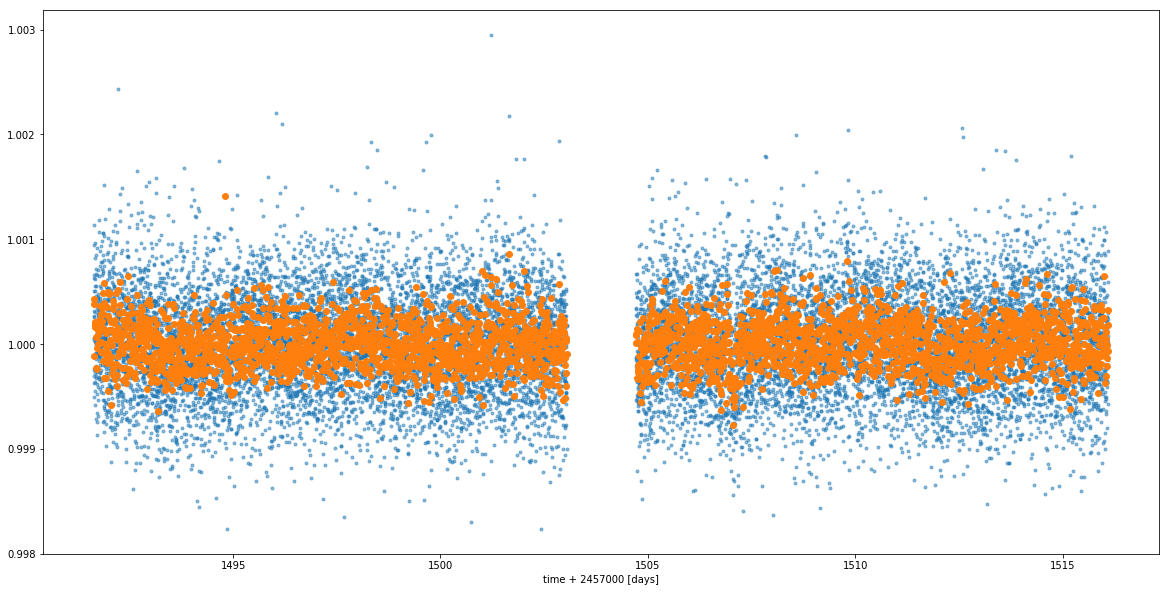

In [46]:
plt.figure(figsize=(20,10))
plt.plot(time, flux, '.',alpha=0.5)
plt.plot(t_bin,y_bin,"o")
plt.xlabel("time + 2457000 [days]")

### Extract points around the visual transit ~1506 to 1509

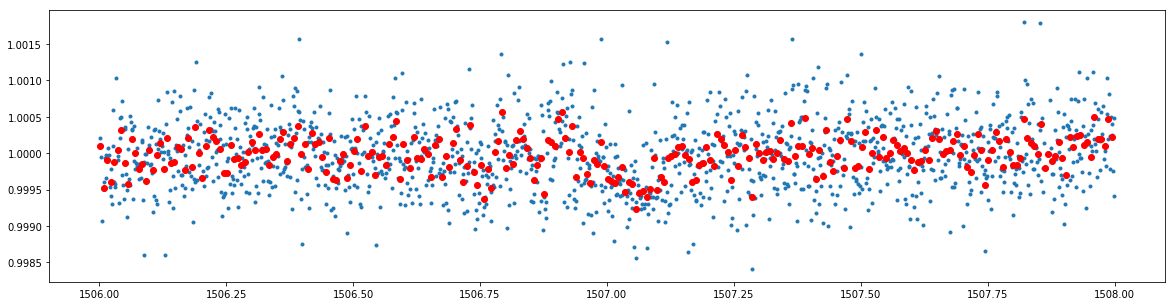

In [47]:
flux_cut, ybin_cut = flux[(time > 1506) & (time < 1508)], y_bin[(t_bin > 1506) & (t_bin < 1508)]
time_cut, tbin_cut = time[(time > 1506) & (time < 1508)], t_bin[(t_bin > 1506) & (t_bin < 1508)]

plt.figure(figsize=(20,5))
plt.plot(time_cut,flux_cut, ".")
plt.plot(tbin_cut,ybin_cut, "ro")

In [ ]:
import batman

def model(params,t, data=None):
    btpar = batman.TransitParams()      #object to store transit parameters
    btpar.t0 = params[0]                #time of inferior conjunction
    btpar.per = params [1]                      #orbital period
    btpar.rp = params[2]                #planet radius (in units of stellar radii)
    btpar.inc = params[3]               #orbital inclination (in degrees)
    btpar.a = params[4]                #semi-major axis (in units of stellar radii)
    btpar.ecc = 0                     #eccentricity
    btpar.w = 90                      #longitude of periastron (in degrees)
    btpar.limb_dark = "quadratic"       #limb darkening model
    btpar.u = [params[5], params[6]]               #limb darkening coefficients
    m = batman.TransitModel(btpar, t,supersample_factor=5, exp_time = 4.431539800545257e-05)    #initializes model
    
    if data is None:
        return m.light_curve(btpar)
    return data - m.light_curve(btpar) 

In [ ]:
from scipy.optimize import least_squares as ls

p0=[1507.064,41.4746,0.02,89.5,48,0.2,0.3]
result=ls(model,p0,args=(time,flux),bounds=([2320,41,0.01,89,45,0.15,0.15],[2322,43,0.05,90,52,0.45,0.45]))

